In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
import time
import random
import sys
from scipy.spatial.distance import cdist
from sklearn import manifold as skm
from collections import defaultdict

NLXHeaderSize = 16384
TETRODERECORDSIZE = 304
RecordOffset = 48
fileName = "data/8360_S32_Sc2/8360_S32_Sc2.Ntt"
numEvents = 3000

insweeps = np.zeros(128, dtype=np.int16)
separateSweeps = np.zeros((4,32),dtype=np.int16)
with open(fileName,'rb') as datafile:
    fd = datafile.fileno()
    fileStat = os.fstat(fd)
    numRecords = int((fileStat.st_size-NLXHeaderSize)/TETRODERECORDSIZE)
    Sweeps = np.zeros((numRecords,4,32),dtype=np.int16)
    startreading = time.time()
    for i in range(0,numRecords):
        datafile.seek(NLXHeaderSize + RecordOffset +(TETRODERECORDSIZE*i))
        insweeps = np.fromfile(datafile,dtype=np.int16,count=128)
        separateSweeps = np.reshape(insweeps,(32,4))
        Sweeps[i,0]=separateSweeps[:,0]
        Sweeps[i,1]=separateSweeps[:,1]
        Sweeps[i,2]=separateSweeps[:,2]
        Sweeps[i,3]=separateSweeps[:,3]
    endreading = time.time()

In [40]:
## Importing the correct data:
fileName = "data/8360_S32_Sc2/8360_S32_Sc2"
offset = 11
numClusters = 8
accurate_results = defaultdict(lambda: []) ## to automatically instantiate new keys
known_spikes = []

for extension in range(numClusters):
    with open(fileName+f'.{extension+1}','r') as datafile:
        for line in datafile.readlines()[offset:]:
            if line.strip() == '0':
                continue
            spikeNum = line.split(sep=',')[0]
            if int(spikeNum) < numEvents:
                accurate_results[f'Neuron {extension+1}'].append(int(spikeNum))
                known_spikes.append(int(spikeNum))

accurate_results = dict(accurate_results)
print(accurate_results['Neuron 1'])

[899, 3826, 4106, 4519, 4525, 5903, 5914, 6089, 6161, 6172, 7820, 7943, 8178, 8368, 8389, 8478, 8481, 8484, 8911, 8945, 9441, 9457, 9600, 9606, 9651, 9652, 9692, 9694, 10588, 10996, 11400, 11403, 11406, 11407, 11410, 11491, 11510, 11529, 11545, 11552, 11559, 11566, 11673, 13061, 13257, 13470, 13980, 14279, 14390]


In [146]:
startreading = time.time()
params = np.zeros((numRecords,12),dtype=np.float32)
peakTime = np.zeros(4,dtype=int)
for i in range(0,numRecords): # recreate calcparms 
    biggest = 0
    maxAmp = 0
    for s in range(0,4):
        temp = Sweeps[i,s,:]*1.0
        params[i,s+8]=np.sqrt(np.sum(np.square(temp)))/6      # energy (I think)
        params[i,s]=np.max(Sweeps[i,s,:])                 # peak -- i, s+4 if uncomment above
        # if params[i,s+4]>biggest:                           # need this for mPeak
        #     maxAmp = params[i,s+4]
        #     biggest = s
        #params[i,s+12]=np.max(Sweeps[i,s,26:31])            # late peak
        params[i,s+4]=np.min(Sweeps[i,s,:])                 # valley
        #params[i,s+24]=np.min(Sweeps[i,s,26:31])            # late valley
        # peakTime[s] = np.argmax(Sweeps[i,s,:])
        # if peakTime[s]< 7:peakTime[s] = 7
        # params[i,s+16]=np.min(Sweeps[i,s,0:peakTime[s]])    # pre valley 
        # mPeaktime = np.argmax(Sweeps[i,biggest,:])          # mpeak
        # if mPeaktime > 1:
        #     start = mPeaktime-2
        # else:
        #     start = 0
        # if mPeaktime <30:
        #     stop = mPeaktime +2
        # else: 
        #     stop = 31
        # params[i,s+12]= max(0,np.max(Sweeps[i,s,start:stop]))
# for i in range(0,2000):
#     whole = np.concatenate((Sweeps[i,0,:],Sweeps[i,1,:],Sweeps[i,2,:],Sweeps[i,3,:]))
#     plt.plot(whole)
# plt.show()
endreading = time.time()
print("parameters calculated: ",endreading-startreading)


parameters calculated:  5.510807752609253


In [147]:
paramnum = 12
dData = np.zeros((numRecords,paramnum),dtype=np.float32)
dData[:] = params[:numRecords,0:paramnum]  #energy & peak
start_time = time.time()
end_time = time.time()


0.6839059


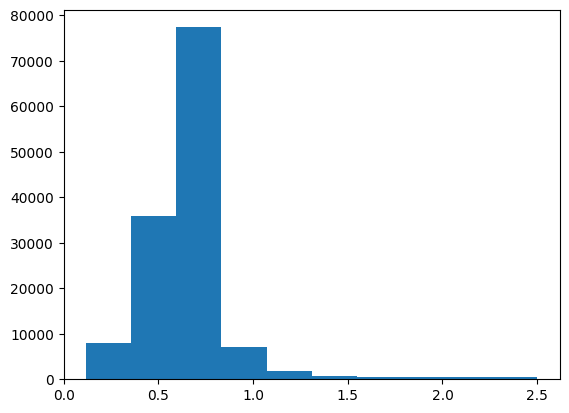

In [153]:
## remove outliers

remove_outliers = True
magnitudes = []
from sklearn.preprocessing import StandardScaler

data = dData**2
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

if remove_outliers:
    for i in range(len(scaled_data)):
        mag = np.linalg.norm((scaled_data[i]))
        if mag > 2.5:
            np.delete(scaled_data,i)
        else:
            magnitudes.append(mag)

print(np.median(magnitudes))
plt.hist(magnitudes)
plt.show()




In [58]:
## run MDS on MDS_data
## will use to compare to non-reduced data

mds = skm.MDS(n_components=3, n_init=3, dissimilarity='precomputed', verbose=1)

MDS_data = mds.fit_transform(distances)

c:\Users\jacob\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_mds.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\jacob\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_mds.py:162: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\jacob\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_mds.py:166: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\jacob\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_mds.py:162: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\jacob\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_mds.py:166: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\jacob\AppData\Local\P

In [149]:
from sklearn.decomposition import PCA

## PCA tests:

pca = PCA(n_components=5, whiten=True)
pca_data = pca.fit_transform(scaled_data)
#print(np.sum(pca.explained_variance_ratio_))

In [37]:
def calculateNeuronalVariance(spikes, mean): ## take in all spikes of a given neuron and calculate the variance
    summed_variance = 0
    for spike in spikes:
        summed_variance += np.linalg.norm(spike-mean)

    return summed_variance/len(spikes)

In [47]:
## Convert to unit vectors
unit_data = np.zeros((numRecords,12))
for i in range(len(data)):
    vector = data[i]/np.linalg.norm(data[i])
    unit_data[i] = vector

results = {} ## formatted as 'Neuron x': [list of spike #s]
unsorted_spikes = []
similarity_threshold = 0.96
isolate_known_spikes = True ## if you want to only look at spikes that have been cluster cut

## Checking dot products to see if they are largest when matched with each other (or highly similar vectors)
## This accounts for directionality in the 4D space.
for curr_spike in range(numEvents): ## lowkey maybe change this to a random sample of all the points?
    closest_match = similarity_threshold ## anything greater than meets threshold
    likeliest_neuron = ''
    if isolate_known_spikes:
        if curr_spike not in known_spikes:
            continue
    for neuron in results.keys(): ## assign spikes to one of the neurons in results (or add a new one)

        first_spike = results[neuron][0] ## to compare directions
        avg_spike = np.sum(data[results[neuron]], axis=0)/len(results[neuron]) ## to calculate variance
        variance = calculateNeuronalVariance(results[neuron], avg_spike)
        dot_product = np.dot(unit_data[first_spike], unit_data[curr_spike])

        if dot_product > closest_match: ## if this vector is more similar to this tetrode amplitude pattern than the previous closest
            dist = np.linalg.norm(avg_spike-curr_spike)
            if dist < variance:
                closest_match = dot_product
                likeliest_neuron = neuron

    if closest_match == similarity_threshold: ## i.e. this spike has not been assigned to a neuron -- none met the threshold
        ## add the next neuron to the dictionary
        num = len(results) + 1 
        results[f'Neuron {num}'] = [curr_spike]

    else:
        results[likeliest_neuron].append(curr_spike)

for i in range(len(results.keys())):
    print(f'Neuron {i+1}: {results[f"Neuron {i+1}"]}')

compare(accurate_results, results)

Neuron 1: [0, 23, 26, 45, 165, 181, 183, 216, 217, 227, 233, 283, 320, 342, 352, 355, 370, 385, 489, 490, 492, 493, 501, 596, 632, 678, 696, 698, 705, 744, 826, 904, 909, 910, 911, 916, 940, 970, 978, 989, 1074, 1075, 1184, 1186, 1198, 1206, 1214, 1239, 1259, 1271, 1277, 1286, 1291, 1439, 1460, 1466, 1467, 1468, 1469, 1480, 1483, 1498, 1500, 1505, 1515, 1519, 1521, 1531, 1541, 1584, 1585, 1628, 1632, 1643, 1813, 1877, 1904, 1937, 1941, 1943, 2022, 2046, 2063, 2140, 2183, 2232, 2266, 2278, 2288, 2292, 2342, 2375, 2377, 2381, 2384, 2385, 2460, 2495, 2500, 2522, 2523, 2559, 2560, 2571, 2573, 2577, 2625, 2665, 2757, 2761, 2764, 2770, 2780, 2838, 2855, 2916, 2943, 2945, 2946, 2966, 3030, 3034, 3036, 3037, 3038, 3039, 3042, 3081, 3087, 3093, 3191, 3205, 3233, 3239, 3445, 3450, 3458, 3514, 3524, 3530, 3534, 3537, 3594, 3627, 3677, 3702, 3811, 3836, 3839, 3870, 3879, 3955, 3958, 3960, 3964, 3974, 4022, 4033, 4064, 4106, 4115, 4117, 4190, 4193, 4289, 4299, 4321, 4324, 4326, 4331, 4333, 4350, 43

0.4123481366331822

899
3826
4106
4519
4525
5903
5914
6089
6161
6172
7820
7943
8178
8368
8389
8478
8481
8484
8911
8945
9441
9457
9600
9606
9651
9652
9692
9694
10588
10996
11400
11403
11406
11407
11410
11491
11510
11529
11545
11552
11559
11566
11673
13061
13257
13470
13980
14279
14390
15167
15252
15416
16248
16251
16577
16853
17013
17109
17800
17804
17922
18046
18049
18054
18317
18345
18773
19044
19113
19931
20905
22089
22367
25030
25035
25460
25632
25694
26279
26369
26370
27906
27907
27908
27914
27925
29503
30234
30357
31432
32057
32662
35750
35752
35755
35757
35759
35760
35775
35780
35782
35801
36003
37607
37720
37750
37771
38537
39390
39465
39467
39477
39652
39811
39812
39912
40579
40622
40625
41602
41618
41620
42113
42115
42120
42415
42536
43194
43271
43329
43335
43346
43524
43550
43679
43821
44428
44615
44878
44905
47228
47596
48841
48859
50023
50194
50704
51981
52431
52435
52442
52446
52452
52462
52481
52518
52532
53069
54058
54131
54260
55364
55507
55527
56116
56136
56262
57111
57790
58117
58625
592

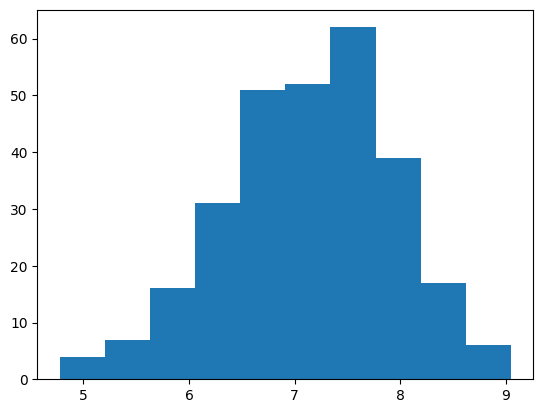

In [ ]:
magnitudes = []
for spike in accurate_results['Neuron 1']:
    magnitudes.append(np.linalg.norm(scaled_data[spike]))

plt.hist(magnitudes)
plt.show()


In [30]:
def compare(accurate_results, results):

    scores = []
    ## Comparing correct data to results
    avg = 0
    ## For each actual neuron, see which of the calculated neurons match its spike pattern most closely 
    for n1 in accurate_results.keys():
        closest_match = ''
        max_score = 0.0
        accurate_spikes = set(accurate_results[n1])
        for n2 in results.keys():
            compared_spikes = set(results[n2])
            longer = np.max([len(accurate_spikes), len(compared_spikes)])
            similarity_score = len(accurate_spikes & compared_spikes)/longer ## spikes in common divided by total
            if similarity_score > max_score:
                closest_match = n2
                max_score = similarity_score

        #print(f'{n1} matched with {closest_match}: {max_score * 100}%')
        scores.append(max_score)
    
    ## isolate top N neurons (i.e. if there are only 8 neurons we know of, only look at the closest 8 to them)
    for i in range(len(accurate_results.keys())):
        avg += np.max(scores) / len(accurate_results.keys())
        scores[np.argmax(scores)] = 0

    #print(avg)
    #print(f'Avg. correctness of {avg*100}%')

    return avg

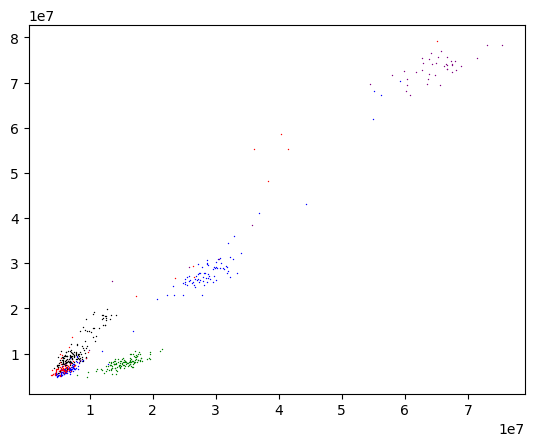

In [132]:
plt.scatter(data[results['Neuron 1'], 0], data[results['Neuron 1'], 1], s=1, linewidths=0, color='blue')
plt.scatter(data[results['Neuron 2'], 0], data[results['Neuron 2'], 1], s=1, linewidths=0, color='red')
plt.scatter(data[results['Neuron 3'], 0], data[results['Neuron 3'], 1], s=1, linewidths=0, color='green')
plt.scatter(data[results['Neuron 4'], 0], data[results['Neuron 4'], 1], s=1, linewidths=0, color='black')
plt.scatter(data[results['Neuron 5'], 0], data[results['Neuron 5'], 1], s=1, linewidths=0, color='purple')

In [126]:
magnitudes = []
log_data = []

print(np.log(scaled_data[0][0]))

for point in scaled_data:
    log_point = [(np.log(abs(point[0]))),(np.log(abs(point[1]))),(np.log(abs(point[2]))),(np.log(abs(point[3]))), 
                 (np.log(abs(point[4]))),(np.log(abs(point[5]))),(np.log(abs(point[6]))),(np.log(abs(point[7])))]
    log_data.append(log_point)

C:\Users\jacob\AppData\Local\Temp\ipykernel_36276\1523370172.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(scaled_data[0][0]))


nan


In [155]:
## data refers to only the points we are sampling right now -- see below code 
def k_means_plus_init(numClusters, data, numPoints):
    ## probabilistically select centroid centers based on distance from each other
    random_start = random.randint(0, numPoints-1)
    centroids = [data[random_start]] ## point nums
    distance_sum = 0.0 ## for scaling everything to sum to 1

    ## for every point, calc its distance from its closest centroid.
    ## then, create a probability distribution that preferentially selects points that are further from their closest centroid.
    for k in range(numClusters-1):
        distances = [] ## each point in data's distance from its closest centroid
        probabilities = []
        distance_sum = 0.0
        for point in range(numPoints):
            min_dist = np.linalg.norm(centroids[0]-data[point]) ## placeholder for comparison
            for centroid in centroids:
                distance = np.linalg.norm(centroid-data[point])
                if distance < min_dist:
                    min_dist = distance
            distances.append(min_dist)
            distance_sum += min_dist**2
        probabilities = np.asarray(distances)**2 / distance_sum
        new_centroid = np.random.choice(np.arange(numPoints), p=probabilities)
        centroids.append(data[new_centroid])
    
    #print(centroids)
    return centroids


In [156]:
## K-means clustering
## cluster based on K number of centroids which serve as anchor points to gauge similarity
## centroids update after each iteration of point assignment, which is then repeated
## stops when centroids stop moving

DATA = np.asarray(pca_data)
K_bounds = (8,11) ## which values of K (# of neurons in this case) to check, widen for accuracy, slows
numIterations = 25 ## max number of iterations, increase for accuracy, slows
numRandomPoints = len(known_spikes) ## only works with a subset of points until the optimal K is determined -- increase for accuracy, slows
numTrials = 20
points = known_spikes
centroids = []
grouped_points = {}
k_means_results = {}
scores = {}

i = 0 ## Had to do this in a while loop since we're only looking at a subset of points.
## Re-do this when looking at full dataset (or don't, it just makes it slower)
# while i < numRandomPoints:
#     point = random.randint(0, numRecords-1)
#     if point in known_spikes:
#         points.append(point)
#         i+=1
for k in range(K_bounds[0], K_bounds[1]):
    peak_score = 0.0
    avg_score = 0.0

    for j in range(numTrials): ## run trials at each K to identify the best one
        score = 0.0
        centroids.clear()
        grouped_points.clear()
        centroids = k_means_plus_init(k, np.asarray(DATA), numRandomPoints)

        for i in range(k):
            #random_centroid = random.randint(0, numRandomPoints-1)
            #centroids.append(scaled_data[random_centroid])
            grouped_points[i] = [] ## holds 4D data
            k_means_results[f'Neuron {i+1}'] = [] ## holds spike #s

        previous_score = 0.0 ## to compare to last iteration, if there was no change, exit early
        for iter in range(numIterations):
            
            grouped_points.update((key, []) for key in grouped_points) ## clear clusters
            k_means_results.update((key, []) for key in k_means_results)
            ## Assigns points to clusters
            for num in range(numRandomPoints):
                point = points[num]
                min_dist = sys.maxsize
                closest_centroid = 0
                for centroid in range(len(centroids)):
                    #print(centroids[centroid])
                    dist = np.linalg.norm(DATA[point]-centroids[centroid])
                    if dist < min_dist:
                        min_dist = dist
                        closest_centroid = centroid
                
                grouped_points[closest_centroid].append(DATA[point])
                k_means_results[f'Neuron {closest_centroid+1}'].append(point)
            
            ## Update cluster centers
            for centroid in grouped_points.keys():
                #print(f'Centroid {centroid}: {len(grouped_points[centroid])}\n')
                grouped_points[centroid] = np.unique(grouped_points[centroid]) ## certain spikes get included twice, need to fix
                center_avg = np.mean(grouped_points[centroid], axis=0)
                #print(center_avg)
                ## If the cluster is dead, i.e. if no points were assigned to it, randomly pick one
                if len(grouped_points[centroid]) != 0:
                    centroids[centroid] = center_avg
                else:
                    centroids[centroid] = DATA[points[random.randint(0, numRandomPoints-1)]]

            score = compare(accurate_results, k_means_results)

            if score != previous_score:
                previous_score = score
            else: 
                break
        avg_score += score / numTrials
        if score > peak_score:
            peak_score = score

    scores[k] = (peak_score, avg_score)

for k_value in scores.keys():
    print(f'K of {k_value}\nPeak: {scores[k_value][0]}\nAverage: {scores[k_value][1]}\n')

c:\Users\jacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


K of 8
Peak: 0.36188922592961076
Average: 0.3222235001831589

K of 9
Peak: 0.31675087186989476
Average: 0.3088534851460665

K of 10
Peak: 0.31034803022770946
Average: 0.2869630549557548



In [151]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=None, n_init=10, init='k-means++').fit_predict(data)
print(len(kmeans))
sklearn_results = defaultdict(lambda: [])

for i in range(len(kmeans)):
    if i in known_spikes:
        sklearn_results[kmeans[i]].append(i)
print(compare(accurate_results, sklearn_results))

138960
0.5285352848867593


In [160]:
import sklearn.cluster as skc

clusterer=skc.HDBSCAN(alpha=1.0,leaf_size=40,metric='euclidean', min_cluster_size=200, min_samples=None, cluster_selection_epsilon=0.3)
clusterer.fit(scaled_data)





HDBSCAN(cluster_selection_epsilon=0.3, min_cluster_size=200)

In [159]:
print(len(np.unique(clusterer.labels_)))

hdbscan_results = defaultdict(lambda: [])

for i in range(len(clusterer.labels_)):
    hdbscan_results[clusterer.labels_[i]].append(i)

compare(accurate_results, hdbscan_results)

9


np.float64(0.13174478914425572)

In [157]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=11, init_params='kmeans', covariance_type='full', max_iter=50, n_init=5).fit(pca_data)
sum = 0.0
for i in range(25):
    
    labels = gmm.predict(pca_data)
    gmm_results = defaultdict(lambda: [])

    for i in range(len(labels)):
        if i in known_spikes:
            gmm_results[int(labels[i])].append(i)


    #print(gmm_results)
    sum += compare(accurate_results, gmm_results)
print(sum/25)

0.5966747598007989
